In [1]:
%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-

## Purpose of notebook 

Here we clean the data that was downloaded from the genbank ftp-server at ftp.ncbi.nih.gov in the 
GenePatents_CreateDb_V3-notebook, and select out the worldwide marine patents. 

## Tech notes
This notebook uses standard packages from the Anaconda-distribution. It has been adjusted for Python 3 from the original notebook written for Python 2.7. This version is called V3. 

# Import libs

In [2]:
import re, sqlite3, gzip
from sqlalchemy import create_engine
import pickle

import numpy as np

from pandas import Series, DataFrame
import pandas as pd

from pprint import pprint
from timeit import default_timer as timer

# File paths

In [4]:
data_folder = '/home/erikz/data/mgr/data/'

DB ='/home/erikz/data/patents_db/genepat_Db_V3.sqlite'
DB ='/home/erikz/data/patents_db/genepat_Db_V4.sqlite'
original_file_path = '/home/erikz/data/agnes_pkl_files/agnes_ori_db.pkl'
filtered_file_path = '/home/erikz/data/agnes_pkl_files/agnes_filtered_db.pkl'

filtered_unknown_file_path = '/home/erikz/data/agnes_pkl_files/filtered_unknown.pkl'
filtered_wa_unknown_file_path = '/home/erikz/data/agnes_pkl_files/filtered_without_unknown.pkl'
filtered_wa_unknown_and_marine_file_path = '/home/erikz/data/agnes_pkl_files/filtered_without_unknown_and_marine.pkl'
filtered_marine_file_path = '/home/erikz/data/mgr/data/filtered_marine_species.pkl'

In [5]:
start1 = timer()
engine = create_engine('sqlite:///%s' % DB)

df = pd.read_sql_query("SELECT * FROM patents;", engine)
end1 = timer()
print('The total runtime is',(end1-start1),' seconds.')

The total runtime is 3302.3417029730044  seconds.


In [6]:
df.head()

,id,locus,organism,definition,journal,filename,origin
0,1,LOCUS A00001 335 bp ...,ORGANISM Cauliflower mosaic virus,DEFINITION Cauliflower mosaic virus satellite...,JOURNAL Patent: EP 0242016-A1 1 21-OCT-1987;...,gbpat1.seq.gz,gttttgtttgatggagaattgcgcagaggggttatatctgcgtgag...
1,2,LOCUS A00002 194 bp ...,ORGANISM Bos taurus,DEFINITION B.taurus DNA sequence 1 from paten...,JOURNAL Patent: EP 0238993-A2 1 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagccgccgtacactgggcc...
2,3,LOCUS A00003 194 bp ...,ORGANISM Bos taurus,DEFINITION B.taurus DNA sequence 2 from paten...,JOURNAL Patent: EP 0238993-A2 2 30-SEP-1987;...,gbpat1.seq.gz,caagctttactaaggaccaccgcaagtacgttcgcagtcttccgcg...
3,4,LOCUS A00004 30 bp ...,ORGANISM synthetic construct,DEFINITION Artificial oligonucleotide sequenc...,JOURNAL Patent: EP 0238993-A2 3 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagc
4,5,LOCUS A00005 18 bp ...,ORGANISM synthetic construct,DEFINITION Artificial oligonucleotide sequenc...,JOURNAL Patent: EP 0238993-A2 4 30-SEP-1987;...,gbpat1.seq.gz,cagaagtccggacgcatg


In [7]:
# 54,820,912 sequences in total (increased from 54,098,444 in Oct 2021)
df.shape # OK! 

(55331424, 7)

# Full Db section
Using the full db, we do some initial cleaning 
and get out the year and patent-string.

In [8]:
# Nr of patents per organism, 14,629 organisms in total
df.organism.value_counts()

ORGANISM  Unknown.                     17541418
ORGANISM  Homo sapiens                 16038032
ORGANISM  synthetic construct          15740909
ORGANISM  unidentified                  1531073
ORGANISM  Saccharomyces pastorianus      977914
                                         ...   
ORGANISM  Moschus berezovskii                 1
ORGANISM  Moschus moschiferus                 1
ORGANISM  Tragulus javanicus                  1
ORGANISM  Tragopan temminckii                 1
ORGANISM  Vibrio plasmid p0908                1
Name: organism, Length: 14710, dtype: int64

In [9]:
# Nr of patents per organism count, hence length 14,629 becomes 73 here
df.organism.apply(lambda x: len(x)).value_counts() # to check they´ve sensible lengths

22     18481033
18     17884985
29     15828367
35      1005668
30       253812
         ...   
102           8
70            5
103           4
76            2
79            1
Name: organism, Length: 73, dtype: int64

In [10]:
# In case we have blanks in organism, replace them with nans 
df['organism'].replace('', np.nan, inplace=True) 

# They all have organism name if 0 length
df[df.organism.isnull()].shape  

(0, 7)

In [11]:
# In case we have blanks in journal, replace them with nans 
df['journal'].replace('', np.nan, inplace=True) 

# These have no journal-info - length around 13,293 
df[df.journal.isnull()].organism.value_counts() 

ORGANISM  Unknown.               10096
ORGANISM  synthetic construct     3108
ORGANISM  Homo sapiens              67
ORGANISM  unidentified              22
Name: organism, dtype: int64

In [12]:
# 0.024% are missing journal info (decreased from 0.025% in Oct 2021) 
(df[df.journal.isnull()].shape[0]*1.0 / df.shape[0])

0.00024024322959770563

In [13]:
# Check shape of full db again
df.shape

(55331424, 7)

In [14]:
# We are also interested in identified patents (not only WO), 
# so we drop those that have no journal info (and these are not marine anyway, see above, so it doesnt matter for us)
df.dropna(subset=['journal'], inplace=True) 

In [15]:
# Check shape after missing journal info is dropped -(54,820,912-54,807,619=)13,293 sequences are dropeed (3 more than Oct 2021)
df.shape

(55318131, 7)

In [16]:
# Change organism names into lowercase and strip them of white spaces
df['organism'] = df.organism.apply(lambda x: x.lower().strip())

In [17]:
df.head()

,id,locus,organism,definition,journal,filename,origin
0,1,LOCUS A00001 335 bp ...,organism cauliflower mosaic virus,DEFINITION Cauliflower mosaic virus satellite...,JOURNAL Patent: EP 0242016-A1 1 21-OCT-1987;...,gbpat1.seq.gz,gttttgtttgatggagaattgcgcagaggggttatatctgcgtgag...
1,2,LOCUS A00002 194 bp ...,organism bos taurus,DEFINITION B.taurus DNA sequence 1 from paten...,JOURNAL Patent: EP 0238993-A2 1 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagccgccgtacactgggcc...
2,3,LOCUS A00003 194 bp ...,organism bos taurus,DEFINITION B.taurus DNA sequence 2 from paten...,JOURNAL Patent: EP 0238993-A2 2 30-SEP-1987;...,gbpat1.seq.gz,caagctttactaaggaccaccgcaagtacgttcgcagtcttccgcg...
3,4,LOCUS A00004 30 bp ...,organism synthetic construct,DEFINITION Artificial oligonucleotide sequenc...,JOURNAL Patent: EP 0238993-A2 3 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagc
4,5,LOCUS A00005 18 bp ...,organism synthetic construct,DEFINITION Artificial oligonucleotide sequenc...,JOURNAL Patent: EP 0238993-A2 4 30-SEP-1987;...,gbpat1.seq.gz,cagaagtccggacgcatg


In [18]:
# Nr of patents per organism count, sorted (length 73 is consistent with run above)
df.organism.apply(lambda x: len(x)).value_counts().sort_index()

13      2307
14        67
15       512
16      3677
17     13869
       ...  
97        18
98        10
102        8
103        4
104       11
Name: organism, Length: 73, dtype: int64

In [19]:
# Nr of unique organisms
df.organism.value_counts().count() 
# len(df.organism.value_counts())

# For the full db (not just WO-only):
# 14,627 unique organisms as compared to 14,355 in Oct 2021 and 12,801 in the original article (272 and 1,826 more respectively)

14708

In [20]:
# Extract year info (from journal string)
# They all have a year, and it´s always before the first semicolon.
def get_year(x):
    try: 
        if x.index(';'):
            return x[x.index(';')-4 : x.index(';')]
    except Exception as e:
        print(x, e)
        return None

df['year'] = None
df['year'] = df.journal.apply(lambda x: get_year(x))

In [21]:
# Patents without year info
df[df.year.isnull()] # They all have year

,id,locus,organism,definition,journal,filename,origin,year


In [22]:
# Check that the years are reasonable 
df.year.value_counts().sort_index()

1979          6
1980         13
1981        130
1982        288
1983        377
1984        757
1985       1522
1986       2226
1987       2091
1988       3296
1989       4462
1990       4367
1991       4267
1992       5060
1993       8329
1994       9413
1995      12174
1996      23806
1997      45391
1998      77116
1999      73780
2000     133487
2001     822508
2002     748221
2003     548625
2004    1289756
2005    3491899
2006    2771339
2007    2426654
2008    3341962
2009    3163915
2010    3769000
2011    2023924
2012    1466600
2013    2212401
2014    1909727
2015    5394533
2016    3559620
2017    2310947
2018    2344058
2019    4148323
2020    2273532
2021    4835122
2022      53107
Name: year, dtype: int64

In [23]:
# Grab patent from journal string  
# They all have one and only one Patent string 
def get_patent(jstr):
    import re
    
    pats = re.findall('Patent: {1,20} ', jstr)
    if not pats or len(pats) > 1:
        #print(pats)
        return None
    else:
        return pats[0]
    
df['patent'] = None
df['patent'] = df.journal.apply(lambda x: get_patent(x))

In [24]:
df.patent

0           EP0242016A1
1           EP0238993A2
2           EP0238993A2
3           EP0238993A2
4           EP0238993A2
               ...     
55331419    US8722325B2
55331420    US8722325B2
55331421    US8722326B2
55331422    US8722326B2
55331423    US8722326B2
Name: patent, Length: 55318131, dtype: object

In [25]:
# Strip patent names of white spaces
#df['patent'] = df.patent.apply(lambda x: x.strip())

In [26]:
# Check that they all have patent-info, and that the data is sensible
#df.
# df[df.patent.isnull()]

In [27]:
print(df.patent.value_counts().sum())
print(df.year.value_counts().sum())

55318131
55318131


In this analysis, we´re interested in all patents (not only WO)

In [28]:
# First check the number of unique organisms - should be 14,627
df.organism.value_counts().count()

14708

In [29]:
df.shape #54,807,619

(55318131, 9)

In [30]:
df.journal.head()

0    JOURNAL   Patent: EP 0242016-A1 1 21-OCT-1987;...
1    JOURNAL   Patent: EP 0238993-A2 1 30-SEP-1987;...
2    JOURNAL   Patent: EP 0238993-A2 2 30-SEP-1987;...
3    JOURNAL   Patent: EP 0238993-A2 3 30-SEP-1987;...
4    JOURNAL   Patent: EP 0238993-A2 4 30-SEP-1987;...
Name: journal, dtype: object

In [31]:
# Extract company info from the journal-string
def get_company(journal):
    
    # Sometimes there is a COMMENT section between JOURNAL & FEATURES... 
    # if so, journal should be cut before it
    if 'COMMENT' in journal:
        journal = journal[:journal.index('COMMENT')]
    
    journal_lines = journal.splitlines()
    
    # The first line is the Patent + Date string
    # If there is company info, this is on the following lines
    if len(journal_lines) > 1: 
        # aggregate together all company lines into one string 
        company = ' '.join([line.strip() for line in journal_lines[1:]]) 
    else: 
        company = None # No company info 
    return company 

df['company'] = None
df['company'] = df.journal.apply(lambda x: get_company(x))

In [32]:
df.head()

,id,locus,organism,definition,journal,filename,origin,year,patent,company
0,1,LOCUS A00001 335 bp ...,organism cauliflower mosaic virus,DEFINITION Cauliflower mosaic virus satellite...,JOURNAL Patent: EP 0242016-A1 1 21-OCT-1987;...,gbpat1.seq.gz,gttttgtttgatggagaattgcgcagaggggttatatctgcgtgag...,1987,EP0242016A1,AGRICULTURAL GENETICS COMPANY LIMITED
1,2,LOCUS A00002 194 bp ...,organism bos taurus,DEFINITION B.taurus DNA sequence 1 from paten...,JOURNAL Patent: EP 0238993-A2 1 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagccgccgtacactgggcc...,1987,EP0238993A2,BAYER AG
2,3,LOCUS A00003 194 bp ...,organism bos taurus,DEFINITION B.taurus DNA sequence 2 from paten...,JOURNAL Patent: EP 0238993-A2 2 30-SEP-1987;...,gbpat1.seq.gz,caagctttactaaggaccaccgcaagtacgttcgcagtcttccgcg...,1987,EP0238993A2,BAYER AG
3,4,LOCUS A00004 30 bp ...,organism synthetic construct,DEFINITION Artificial oligonucleotide sequenc...,JOURNAL Patent: EP 0238993-A2 3 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagc,1987,EP0238993A2,BAYER AG
4,5,LOCUS A00005 18 bp ...,organism synthetic construct,DEFINITION Artificial oligonucleotide sequenc...,JOURNAL Patent: EP 0238993-A2 4 30-SEP-1987;...,gbpat1.seq.gz,cagaagtccggacgcatg,1987,EP0238993A2,BAYER AG


In [33]:
df['origin'].head()

0    gttttgtttgatggagaattgcgcagaggggttatatctgcgtgag...
1    aattcatgcgtccggacttctgcctcgagccgccgtacactgggcc...
2    caagctttactaaggaccaccgcaagtacgttcgcagtcttccgcg...
3                       aattcatgcgtccggacttctgcctcgagc
4                                   cagaagtccggacgcatg
Name: origin, dtype: object

In [34]:
# Patents without company info
df[df.company.isnull()].shape # 925,971 missing company info (increased from 925,010 in Oct 2021) 

(937388, 10)

In [35]:
# 1.7% are missing company info (same with that in Oct 2021)
(df[df.company.isnull()].shape[0]*1.0/df.shape[0])

0.016945402584190705

In [36]:
# The ones we didn´t get a company name for, the common species don´t seem to be marine - length is 1,095
df[df.company.isnull()].organism.value_counts()

organism  unknown.                       758381
organism  unidentified                   116713
organism  homo sapiens                    31804
organism  corynebacterium glutamicum       8128
organism  synthetic construct              7816
                                          ...  
organism  rasamsonia emersonii                1
organism  colletotrichum sp.                  1
organism  mycolicibacterium wolinskyi         1
organism  artemisia annua                     1
organism  cladorrhinum foecundissimum         1
Name: organism, Length: 1095, dtype: int64

<AxesSubplot:>

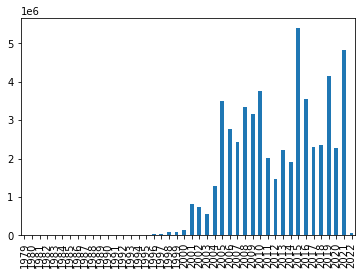

In [37]:
# Total patents by year - plotted
df.year.value_counts().sort_index().plot(kind='bar')

In [38]:
# Organism count based on index (iloc), sorted
df.iloc[:].organism.apply(lambda x: len(x)).value_counts().sort_index()

13      2307
14        67
15       512
16      3677
17     13869
       ...  
97        18
98        10
102        8
103        4
104       11
Name: organism, Length: 73, dtype: int64

In [39]:
len(df) #54,807,619

55318131

In [40]:
# A list with all unique species (n=14,627) 
df.organism.value_counts()

organism  unknown.                     17531322
organism  homo sapiens                 16037965
organism  synthetic construct          15737801
organism  unidentified                  1531051
organism  saccharomyces pastorianus      977914
                                         ...   
organism  moschus berezovskii                 1
organism  moschus moschiferus                 1
organism  tragulus javanicus                  1
organism  tragopan temminckii                 1
organism  dama dama                           1
Name: organism, Length: 14708, dtype: int64

In [41]:
# All organism names in df starts with 'organism', but with some variations
df.organism.apply(lambda x: x.startswith('organism ')).value_counts() #54,806,384
# not all organisms start with 'organism ' with one space at the end - only 54,806,384

True     55316872
False        1259
Name: organism, dtype: int64

In [42]:
# 1,235 starts with 'organism,' or 'organisms', checked here: 
df.organism.apply(lambda x: x.startswith('organism,')).value_counts() #63 with ','

False    55318044
True           87
Name: organism, dtype: int64

In [43]:
df.organism.apply(lambda x: x.startswith('organisms')).value_counts() #1172 with 's'

False    55316959
True         1172
Name: organism, dtype: int64

In [47]:
df.origin.drop_duplicates()

0           gttttgtttgatggagaattgcgcagaggggttatatctgcgtgag...
1           aattcatgcgtccggacttctgcctcgagccgccgtacactgggcc...
2           caagctttactaaggaccaccgcaagtacgttcgcagtcttccgcg...
3                              aattcatgcgtccggacttctgcctcgagc
4                                          cagaagtccggacgcatg
                                  ...                        
55331130    gacatccagatgacccagtctccatccaccctgtctgcatctgtag...
55331131    gaagtgcagctggtgcagtctggagctgaggtgaagaagcctgggg...
55331132    gacacccagatgacccagtctccatccttcctgtctgcatctgtag...
55331133    gaggtgcagctggtggagtccgggggagtcgtggtacagcctgggg...
55331134    ccgacatccagatgacccagtctccatcctccctgtctgcatctgt...
Name: origin, Length: 24600503, dtype: object

In [45]:
original_file_path = '/home/erikz/data/agnes_pkl_files/erik_ori_db_cp.pkl'

In [46]:
with open(original_file_path, 'wb') as f:
    pickle.dump(df, f)

# Read Agnes database (Erik)

In [7]:
from auxilary_functions import *

In [8]:
df2 = pd.read_pickle(original_file_path)

In [10]:
df2['organism'] = df2.organism.apply(lambda x: x[9:].strip())

In [13]:
from phonetisch import soundex

In [11]:
df2.organism.value_counts()

unknown.                                   17284277
homo sapiens                               15878779
synthetic construct                        15650123
unidentified                                1529842
saccharomyces pastorianus                    977914
                                             ...   
sulfuricurvum sp. pc08-66                         1
bacteroidetes oral taxon 274 str. f0058           1
lachnospiraceae bacterium md335                   1
proteocatella sphenisci                           1
lipomyces kononenkoae                             1
Name: organism, Length: 14627, dtype: int64

In [14]:
df2['encode'] = df2.organism.apply(lambda x: soundex.encode_word(x))

In [15]:
# Load file with marine species (1,488 organisms), received from Robert Blasiak on 7 Jan 2022 + additional 12 on 11 Mar 2022
marine_species_file = data_folder+'Marine_species_V3.xlsx'
mdf = pd.read_excel(marine_species_file)

# Just strip any spaces that might have occured, just in case
mdf.organism = mdf.organism.apply(lambda x: x.strip()) 

In [16]:
mdf['encode'] = mdf.organism.apply(lambda x: soundex.encode_word(x))

In [17]:
df_marine_phonetics = df2.merge(mdf, left_on='encode', right_on='encode', how='inner')

In [18]:
df_marine_phonetics

,id,locus,organism_x,definition,journal,filename,origin,valid_sequence,year,patent,company,encode,organism_y
0,2390,LOCUS A05174 2190 bp ...,anguilla anguilla,DEFINITION Synthetic nucleotide sequence of e...,JOURNAL Patent: WO 8803949-A1 2 02-JUN-1988;,gbpat1.seq.gz,cgataacaccggtaaacaatcgtcactgtaggtctaaactacaaac...,1,1988,Patent: WO,None,A524524,anguilla anguilla
1,7246380,LOCUS JB138172 63 bp ...,anguilla anguilla,DEFINITION Sequence 35 from Patent WO2012160278.,JOURNAL Patent: WO 2012160278-A1 35 29-NOV-2...,gbpat131.seq.gz,cctcgaataacaataaagacaattcataaaacaataagaacaaaaa...,1,2012,Patent: WO,"UNIV GRENOBLE 1 [FR], CENTRE NAT RECH SCIENT [...",A524524,anguilla anguilla
2,8038155,LOCUS JC331750 99 bp ...,anguilla anguilla,DEFINITION Sequence 90 from Patent WO2012160277.,JOURNAL Patent: WO 2012160277-A1 90 29-NOV-2...,gbpat135.seq.gz,tcaaccttaaacaacgatgacaacatacaaatatcatccgccaggg...,1,2012,Patent: WO,"UNIV GRENOBLE 1 [FR], CENTRE NAT RECH SCIENT [...",A524524,anguilla anguilla
3,14184745,LOCUS DD177773 19 bp ...,anguilla anguilla,DEFINITION Method for the detection and/or id...,JOURNAL Patent: JP 2005514037-A 42 19-MAY-20...,gbpat16.seq.gz,atacctttacatagaaaca,1,2005,Patent: JP,Bio Merieux,A524524,anguilla anguilla
4,19648958,LOCUS DI140281 1646 bp ...,anguilla anguilla,DEFINITION Methods for Identifying Compounds ...,JOURNAL Patent: KR 1020067001172-A 27 18-JAN...,gbpat19.seq.gz,ggattgatgacatacaaacttctggtaagctggtagcaatggtaag...,1,2006,Patent: KR,None,A524524,anguilla anguilla
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71151,53322078,LOCUS HH982244 660 bp ...,chiridius poppei,DEFINITION Sequence 2 from Patent EP1734117.,JOURNAL Patent: EP 1734117-A1 2 20-DEC-2006;...,gbpat94.seq.gz,atgacaaccttcaaaatcgagtcccggatccatggcaacctcaacg...,1,2006,Patent: EP,NEC SOFTWARE LTD [JP],C63211,chiridius poppei
71152,53322079,LOCUS HH982245 782 bp ...,chiridius poppei,DEFINITION Sequence 3 from Patent EP1734117.,JOURNAL Patent: EP 1734117-A1 3 20-DEC-2006;...,gbpat94.seq.gz,agaacactcagtgtatccagttttccgtcctactacaaacatgaca...,1,2006,Patent: EP,NEC SOFTWARE LTD [JP],C63211,chiridius poppei
71153,53344286,LOCUS HI070956 1041 bp ...,pyrodictium,DEFINITION Sequence 957 from Patent EP1869173.,JOURNAL Patent: EP 1869173-A2 957 26-DEC-200...,gbpat94.seq.gz,atgaaactccttgagcccacaaatacctcctacacgctgttacagg...,1,2007,Patent: EP,VERENIUM CORP [US],P63235,pyrodictium
71154,53559369,LOCUS HI377953 663 bp ...,corynactis viridis,DEFINITION Sequence 4 from Patent EP2104681.,JOURNAL Patent: EP 2104681-A2 4 30-SEP-2009;...,gbpat95.seq.gz,atgagcctgagcaagcacgtgatcgcccaggacgtgaccatgatct...,1,2009,Patent: EP,INSERON INC [US],C652321632,corynactis viridis


In [19]:
with open('/home/erikz/data/mgr/data/soundex_marine_species.pkl', 'wb') as f:
    pickle.dump(df_marine_phonetics, f)

# Filter for valid sequences

In [5]:
import re

def match(column):
    all_nucs = 'agtc'
    
    if all(i in all_nucs for i in column):
        return 1
    else:
        return None

In [ ]:
df['valid_sequence'] = df.apply(lambda x: match(x['origin']),axis=1)

In [ ]:
df[df.valid_sequence.isnull()]

In [ ]:
seq_lens = df['origin'].tolist()
df['seq_len'] = [len(i) for i in seq_lens]

filtered_df = df.loc[(df['seq_len'] >30) &\
                       (df.company.isna() == False) &\
                       (df['valid_sequence'] == 1)]

In [ ]:
filtered_df

In [ ]:
with open(filtered_file_path, 'wb') as f:
    pickle.dump(filtered_df, f)

In [6]:
### Uncomment to read back

filtered_df = pd.read_pickle(filtered_file_path) 

# Marine-only

In our study, we are only interested in marine species. 
To get these, we extract a list of all unique organism names from the all patents (14,627 organisms). 
Robert Blasiak then manually goes through them and indicates which ones are marine; it results in 1,488 marine species (1,476 species from Oct 2021 + additional 12 from Mar 2022).
Details about this process can be given by Robert, main author of the paper. 

In [6]:
# Load file with marine species (1,488 organisms), received from Robert Blasiak on 7 Jan 2022 + additional 12 on 11 Mar 2022
marine_species_file = data_folder+'Marine_species_V3.xlsx'
mdf = pd.read_excel(marine_species_file)

In [7]:
# Just strip any spaces that might have occured, just in case
mdf.organism = mdf.organism.apply(lambda x: x.strip()) 

In [9]:
mdf.organism.to_csv('/home/erik/SRC/research/mgr/data/marine_species_names.tsv', sep="\t", index=False, header=False)

In [6]:
filtered_df['organism'] = filtered_df.organism.apply(lambda x: x[9:].strip())

NameError: name 'filtered_df' is not defined

In [8]:
df['organism'] = df.organism.apply(lambda x: x[9:].strip())

In [9]:
# Keep only the marine sequences from df
df_marine = df.merge(mdf, left_on='organism', right_on='organism', how='inner')

In [10]:
df_marine.shape #should be 54,042 patents

(54042, 11)

In [13]:
df_marine

,id,locus,organism,definition,journal,filename,origin,valid_sequence,year,patent,company
0,2390,LOCUS A05174 2190 bp ...,anguilla anguilla,DEFINITION Synthetic nucleotide sequence of e...,JOURNAL Patent: WO 8803949-A1 2 02-JUN-1988;,gbpat1.seq.gz,cgataacaccggtaaacaatcgtcactgtaggtctaaactacaaac...,1,1988,Patent: WO,None
1,7246380,LOCUS JB138172 63 bp ...,anguilla anguilla,DEFINITION Sequence 35 from Patent WO2012160278.,JOURNAL Patent: WO 2012160278-A1 35 29-NOV-2...,gbpat131.seq.gz,cctcgaataacaataaagacaattcataaaacaataagaacaaaaa...,1,2012,Patent: WO,"UNIV GRENOBLE 1 [FR], CENTRE NAT RECH SCIENT [..."
2,8038155,LOCUS JC331750 99 bp ...,anguilla anguilla,DEFINITION Sequence 90 from Patent WO2012160277.,JOURNAL Patent: WO 2012160277-A1 90 29-NOV-2...,gbpat135.seq.gz,tcaaccttaaacaacgatgacaacatacaaatatcatccgccaggg...,1,2012,Patent: WO,"UNIV GRENOBLE 1 [FR], CENTRE NAT RECH SCIENT [..."
3,14184745,LOCUS DD177773 19 bp ...,anguilla anguilla,DEFINITION Method for the detection and/or id...,JOURNAL Patent: JP 2005514037-A 42 19-MAY-20...,gbpat16.seq.gz,atacctttacatagaaaca,1,2005,Patent: JP,Bio Merieux
4,19648958,LOCUS DI140281 1646 bp ...,anguilla anguilla,DEFINITION Methods for Identifying Compounds ...,JOURNAL Patent: KR 1020067001172-A 27 18-JAN...,gbpat19.seq.gz,ggattgatgacatacaaacttctggtaagctggtagcaatggtaag...,1,2006,Patent: KR,None
...,...,...,...,...,...,...,...,...,...,...,...
54037,53322078,LOCUS HH982244 660 bp ...,chiridius poppei,DEFINITION Sequence 2 from Patent EP1734117.,JOURNAL Patent: EP 1734117-A1 2 20-DEC-2006;...,gbpat94.seq.gz,atgacaaccttcaaaatcgagtcccggatccatggcaacctcaacg...,1,2006,Patent: EP,NEC SOFTWARE LTD [JP]
54038,53322079,LOCUS HH982245 782 bp ...,chiridius poppei,DEFINITION Sequence 3 from Patent EP1734117.,JOURNAL Patent: EP 1734117-A1 3 20-DEC-2006;...,gbpat94.seq.gz,agaacactcagtgtatccagttttccgtcctactacaaacatgaca...,1,2006,Patent: EP,NEC SOFTWARE LTD [JP]
54039,53344286,LOCUS HI070956 1041 bp ...,pyrodictium,DEFINITION Sequence 957 from Patent EP1869173.,JOURNAL Patent: EP 1869173-A2 957 26-DEC-200...,gbpat94.seq.gz,atgaaactccttgagcccacaaatacctcctacacgctgttacagg...,1,2007,Patent: EP,VERENIUM CORP [US]
54040,53559369,LOCUS HI377953 663 bp ...,corynactis viridis,DEFINITION Sequence 4 from Patent EP2104681.,JOURNAL Patent: EP 2104681-A2 4 30-SEP-2009;...,gbpat95.seq.gz,atgagcctgagcaagcacgtgatcgcccaggacgtgaccatgatct...,1,2009,Patent: EP,INSERON INC [US]


In [11]:
df_marine.to_csv('/mnt/data/erikz/df_worms_species.csv', sep='\t', header=True, index=False)

In [54]:
df_filtered_marine.organism.value_counts().sort_index() #top 20

[bacillus] caldolyticus          5
acanthastrea echinata            8
acanthopagrus schlegelii         2
acanthus ebracteatus             2
acaryochloris                    1
                                ..
zoarces elongatus                1
zoarces viviparus                1
zobellia galactanivorans        13
zostera marina                  16
zunongwangia profunda sm-a87     1
Name: organism, Length: 1366, dtype: int64

In [ ]:
with open('/mnt/data/erikz/mgr/data/filtered_marine_species.pkl', 'wb') as f:
    pickle.dump(df_filtered_marine, f)

# Unknown-only 

In [7]:
filtered_df.organism.value_counts()[:50] #top 20

organism  unknown.                             7384257
organism  homo sapiens                         4308483
organism  synthetic construct                  4000312
organism  unidentified                         1064162
organism  mus musculus                          313591
organism  zea mays                              309659
organism  glycine max                           106775
organism  arabidopsis thaliana                   79807
organism  saccharomyces pastorianus              78785
organism  oryza sativa                           74393
organism  rattus norvegicus                      56161
organism  aspergillus oryzae                     53932
organism  escherichia coli                       49154
organism  saccharomyces cerevisiae               46303
organism  bacillus licheniformis                 45710
organism  staphylococcus aureus                  37917
organism  streptococcus agalactiae               35913
organism  drosophila sp. (in: insecta)           29166
organism  

In [33]:
filtered_df_unknown = filtered_df[filtered_df["organism"].isin(["unknown.","unidentified", "synthetic construct"])]

In [35]:
filtered_df_unknown.patent.value_counts()

Patent: US    7384263
Patent: JP    3400054
Patent: WO     600543
Patent: EP     587760
Patent: KR     475865
Patent: DE        131
Patent: FR        100
Patent: GB         10
Patent: NO          5
Name: patent, dtype: int64

In [36]:
len(np.unique(filtered_df_unknown.origin))

5568733

In [37]:
filtered_df_unknown.organism.value_counts()

unknown.               7384257
synthetic construct    4000312
unidentified           1064162
Name: organism, dtype: int64

In [38]:
with open(filtered_unknown_file_path, 'wb') as f:
    pickle.dump(filtered_df_unknown, f)

## What is patent distribution for sequences >150 bp?

In [17]:
pd.options.display.float_format = '{:20,.4f}'.format

In [6]:
filtered_df_unknown = pd.read_pickle(filtered_unknown_file_path) 

In [7]:
filtered_df_unknown['seq_length'] = filtered_df_unknown.origin.apply(lambda x: len(x))
filtered_df_unknown = filtered_df_unknown[filtered_df_unknown['seq_length']>=150]

In [18]:
filtered_df_unknown.patent.value_counts()/filtered_df_unknown.patent.value_counts().sum()

Patent: US                 0.7097
Patent: JP                 0.1893
Patent: EP                 0.0440
Patent: WO                 0.0332
Patent: KR                 0.0238
Patent: DE                 0.0000
Patent: FR                 0.0000
Patent: GB                 0.0000
Patent: NO                 0.0000
Name: patent, dtype: float64

In [16]:
filtered_df_unknown.origin.value_counts().sum()

7467396

# Filtered without unknown

In [39]:
filtered_df_wa_unknown = filtered_df[~filtered_df["organism"].isin(["unknown.","unidentified", "synthetic construct"])]

In [40]:
filtered_df_wa_unknown.patent.value_counts()

Patent: JP    2797920
Patent: WO    2106403
Patent: EP    1659152
Patent: KR     185829
Patent: DE        231
Patent: FR         65
Patent: GB         15
Patent: CH          3
Patent: US          1
Patent: NO          1
Name: patent, dtype: int64

In [41]:
len(np.unique(filtered_df_wa_unknown.origin))

3549633

In [62]:
#print(sorted(filtered_df_wa_unknown.organism.value_counts().index))

["'nostoc azollae' 0708", ', methods.organism  alicyclobacillus acidocaldarius', ', methods.organism  synthetic construct', '.organism  saccharomyces cerevisiae', '.organism  saccharomyces cerevisiaeorganisms', '.organism  synthetic construct', '.organism  synthetic constructorganisms', '[actinobacillus] rossii', '[bacillus thuringiensis] serovar konkukian', '[bacillus thuringiensis] serovar konkukian str. 97-27', '[bacillus] caldolyticus', '[bacillus] caldotenax', '[bacillus] caldovelox', '[bacillus] selenitireducens mls10', '[bacteroides] coagulans', '[bacteroides] pectinophilus', '[bacteroides] pectinophilus atcc 43243', '[brevibacterium] flavum', '[brevibacterium] frigoritolerans', '[candida] arabinofermentans', '[candida] auris', '[candida] boidinii', '[candida] cloacae', '[candida] glabrata', '[candida] glabrata cbs 138', '[candida] haemuloni', '[candida] inconspicua', '[candida] intermedia', '[candida] maris', '[candida] mengyuniae', '[candida] nemodendra', '[candida] norvegica'

In [63]:
#print(sorted(df_filtered_marine.organism.value_counts().index))

['[bacillus] caldolyticus', 'acanthastrea echinata', 'acanthopagrus schlegelii', 'acanthus ebracteatus', 'acaryochloris', 'acaryochloris marina', 'acaryochloris marina mbic11017', 'acetabularia acetabulum', 'acinetobacter marinus', 'acropora', 'acropora aculeus', 'acropora aspera', 'acropora formosa', 'acropora hyacinthus', 'acropora millepora', 'acropora robusta', 'actinia equina', 'aequorea', 'aequorea coerulescens', 'aequorea macrodactyla', 'aequorea victoria', 'aeromonas molluscorum 848', 'aeromonas salmonicida', 'aeromonas salmonicida subsp. salmonicida', 'aeromonas salmonicida subsp. salmonicida a449', 'aeropyrum pernix', 'aeropyrum pernix k1', 'agaricia fragilis', 'agarivorans albus', 'agarophyton vermiculophyllum', 'alatina alata', 'alcanivorax', 'alcanivorax borkumensis', 'alcanivorax borkumensis sk2', 'alcanivorax hongdengensis', 'alcanivorax jadensis', 'alcanivorax pacificus', 'alexandrium', 'alexandrium catenella', 'alexandrium fundyense', 'alexandrium minutum', 'alexandriu

In [43]:
with open(filtered_wa_unknown_file_path, 'wb') as f:
    pickle.dump(filtered_df_wa_unknown, f)

# Filtered without unknown and marine

In [44]:
filtered_df_wa_unknown_and_marine = filtered_df_wa_unknown[~filtered_df_wa_unknown["organism"].isin(df_filtered_marine["organism"])]

In [45]:
filtered_df_wa_unknown_and_marine.organism.value_counts()[:50]

homo sapiens                         4308483
mus musculus                          313591
zea mays                              309659
glycine max                           106775
arabidopsis thaliana                   79807
saccharomyces pastorianus              78785
oryza sativa                           74393
rattus norvegicus                      56161
aspergillus oryzae                     53932
escherichia coli                       49154
saccharomyces cerevisiae               46303
bacillus licheniformis                 45710
staphylococcus aureus                  37917
streptococcus agalactiae               35913
drosophila sp. (in: insecta)           29166
streptococcus pneumoniae               26916
neisseria meningitidis                 25157
actinoplanes utahensis                 24089
artificial sequences                   22921
streptococcus pyogenes                 22131
corynebacterium glutamicum             20941
nicotiana tabacum                      17931
neisseria 

In [46]:
with open(filtered_wa_unknown_and_marine_file_path, 'wb') as f:
    pickle.dump(filtered_df_wa_unknown_and_marine, f)

In [47]:
filtered_df_wa_unknown_and_marine.sample(10)

,id,locus,organism,definition,journal,filename,origin,valid_sequence,year,patent,company,seq_len
8347890,8347891,LOCUS JC783824 364 bp ...,zea mays,DEFINITION Sequence 34199 from Patent WO20140...,JOURNAL Patent: WO 2014036048-A1 34199 06-MA...,gbpat137.seq.gz,gtgaaatctatgcatattcgccacttgccacttttcttcttgacca...,1.0,2014,Patent: WO,DU PONTa [US],364
7644730,7644731,LOCUS JB730716 94 bp ...,homo sapiens,DEFINITION Sequence 119 from Patent WO2013082...,JOURNAL Patent: WO 2013082448-A1 119 06-JUN-...,gbpat134.seq.gz,aggatctgcgcacaaagctcctgagcctgaagctgtcccatacccg...,1.0,2013,Patent: WO,"UNIV KANSAS [US], WEINER CARL PHILIP [US], DON...",94
14042729,14042730,LOCUS DD035485 2070 bp ...,homo sapiens,DEFINITION Full length cDNA.,JOURNAL Patent: JP 2004222720-A 1215 12-AUG-...,gbpat16.seq.gz,agcctgtggaactatgagccaattcaacctcttttcttcataaatt...,1.0,2004,Patent: JP,Research Association for Biotechnology,2070
14757710,14757711,LOCUS LQ741374 321 bp ...,homo sapiens,DEFINITION Sequence 47 from Patent WO2018083248.,JOURNAL Patent: WO 2018083248-A1 47 11-MAY-2...,gbpat161.seq.gz,gacatccagatgacccagtctccatcctccctgtctgcatctgtag...,1.0,2018,Patent: WO,KYMAB LTD [GB],321
14076770,14076771,LOCUS DD069526 2895 bp ...,chlamydia trachomatis,DEFINITION VACCINE COMPOSITION.,JOURNAL Patent: JP 2004527480-A 7 09-SEP-200...,gbpat16.seq.gz,atgaaaaaagcgtttttctttttccttatcggaaactccctatcag...,1.0,2004,Patent: JP,GLAXOSMITHKLINE BIOLOGICALS S A,2895
51357351,51357352,LOCUS BD475816 60 bp ...,homo sapiens,DEFINITION OLIGONUCLEOTIDE LIBRARY FOR DETECT...,JOURNAL Patent: JP 2004508019-A 14938 18-MAR...,gbpat9.seq.gz,gagcaagagcttcatgacatccactctactcgctccaaagagcggc...,1.0,2004,Patent: JP,"Avi SHOSHAN,Alon WASSERMAN,Eli MINTZ,Liat MINT...",60
53675986,53675987,LOCUS HI531903 566 bp ...,glycine max,DEFINITION Sequence 2875 from Patent EP2148885.,JOURNAL Patent: EP 2148885-A2 2875 03-FEB-20...,gbpat96.seq.gz,atggactaaagtttccaagggtaagcatatatagaggtcaccctgt...,1.0,2010,Patent: EP,MONSANTO TECHNOLOGY LLC [US],566
14064504,14064505,LOCUS DD057260 315 bp ...,rattus,DEFINITION Feeding-regulating agent.,JOURNAL Patent: WO 2004084945-A 11 07-OCT-20...,gbpat16.seq.gz,atgagaggtgctgtgcaagtcttcatcatgctccttctagcaactg...,1.0,2004,Patent: WO,Takeda Chemical Industries Ltd,315
36403587,36403588,LOCUS FU299285 1338 bp ...,homo sapiens,DEFINITION Transcriptome Microarray Technolog...,JOURNAL Patent: JP 2008518610-A 27228 05-JUN...,gbpat36.seq.gz,aaattgaagcaaatcaacagcaaatacagcaggattcagggaggct...,1.0,2008,Patent: JP,Arradx Limited,1338
36536495,36536496,LOCUS FU432193 1000 bp ...,homo sapiens,DEFINITION Transcriptome Microarray Technolog...,JOURNAL Patent: JP 2008518610-A 160136 05-JU...,gbpat37.seq.gz,ttttttttttttttttttgaggccagactatttattacaacctact...,1.0,2008,Patent: JP,Arradx Limited,1000


In [ ]:
#check that marine species are not present

In [ ]:
#import fuzzy
#soundex = fuzzy.Soundex(4)

# Misc (playing around)

### Filter for duplicates

In [144]:
ids = filtered_df["origin"]
df_duplicates = filtered_df[ids.isin(ids[ids.duplicated()])]

In [145]:
df_duplicates.sort_values("origin")

id                                                                            locus             organism                                                                      definition  \
25115066  25115067  LOCUS       MM220554                  31 bp    DNA     linear   PAT 07-DEC-2018  unknown.             DEFINITION  Sequence 831 from patent US 10131958.                                
27144366  27144367  LOCUS       MP244173                  31 bp    DNA     linear   PAT 14-SEP-2019  synthetic construct  DEFINITION  Sequence 831 from Patent EP3480321.                                  
11354717  11354718  LOCUS       KH548805                  31 bp    DNA     linear   PAT 13-OCT-2017  unknown.             DEFINITION  Sequence 831 from patent US 9567646.                                 
11353874  11353875  LOCUS       KH547962                  31 bp    DNA     linear   PAT 13-OCT-2017  unknown.             DEFINITION  Sequence 831 from patent US 9567645.                                 
12808037  12808038  LOCUS       LF943618                  31 bp    DNA     linear   PAT 28-FEB-2017  synthetic construct  DEFINITION  JP 2016533187-A/831: MASSIVELY PARALLEL SINGLE CELL ANALYSIS.        
...            ...                                                                              ...                  ...                                                                        ...        
14604431  14604432  LOCUS       LQ422954                5000 bp    DNA     linear   PAT 06-OCT-2016  synthetic construct  DEFINITION  Sequence 32 from Patent WO2016109410.                                
14209036  14209037  LOCUS       LP754112                5000 bp    DNA     linear   PAT 29-APR-2018  synthetic construct  DEFINITION  Sequence 55 from Patent WO2018026953.                                
23702512  23702513  LOCUS       MI097677                5000 bp    DNA     linear   PAT 12-FEB-2018  unknown.             DEFINITION  Sequence 32 from patent US 9777061.                                  
20565302  20565303  LOCUS       MC007582                5016 bp    DNA     linear   PAT 29-MAY-2020  synthetic construct  DEFINITION  JP 2020500530-A/726: SYNTHETIC IMMUNE RECEPTORS AND METHODS OF USE   
33944451  33944452  LOCUS       PA344211                5016 bp    DNA     linear   PAT 28-JAN-2022  synthetic construct  DEFINITION  JP 2021525509-A/121: DIVERSE ANTIGEN BINDING DOMAINS, NOVEL          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       journal         filename  \
25115066  JOURNAL   Patent: US 10131958-B1 831 20-NOV-2018;\n            Cellular Research, Inc.; Menlo Park, CA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [146]:
df_duplicates_grouped = df_duplicates.groupby('origin').sum().reset_index()
df_duplicates_grouped.sort_values('valid_sequence', ascending=False)

,origin,id,valid_sequence,seq_len
1829934,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,122278904836,2494.0,231942
2646140,gcccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtaggt,104775703315,2137.0,203015
2878802,ggccatggtggtctgataggatacatgggacaatttcaatatttttgtatctattgaggcctgttttgtgaccaattatatggtc,76029316175,1549.0,131665
2059934,cgggcaagtcagggcattagaaatgatttaggc,24341699592,947.0,31251
2878807,ggccatggtggtctgataggatacatgggacaatttcaatatttttgtatctgttgaggcctgttttgtgaccaattatatggtc,41425075334,844.0,71740
...,...,...,...,...
2289950,cttgcctccacacctttgtcctccagtttagt,54097444,2.0,64
2289951,cttgcctccaccatgatatttgaataagagatggccagaggataacacttgtctcttaaaaact,81096646,2.0,128
2289952,cttgcctccactcaccacaagctgagcaggac,54097446,2.0,64
2289953,cttgcctcccaaagtgctaagattacagcctc,54097450,2.0,64


In [147]:
df_duplicates.loc[df_duplicates['origin'] == 'cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg']

,id,locus,organism,definition,journal,filename,origin,valid_sequence,year,patent,company,seq_len
49001889,49001890,LOCUS GZ879165 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 69 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 69 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
49001906,49001907,LOCUS GZ879182 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 86 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 86 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
49001922,49001923,LOCUS GZ879198 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 102 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 102 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
49001924,49001925,LOCUS GZ879200 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 104 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 104 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
49001926,49001927,LOCUS GZ879202 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 106 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 106 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
...,...,...,...,...,...,...,...,...,...,...,...,...
49059161,49059162,LOCUS GZ936437 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 57341 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 57341 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
49059163,49059164,LOCUS GZ936439 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 57343 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 57343 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
49059169,49059170,LOCUS GZ936445 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 57349 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 57349 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93
49059204,49059205,LOCUS GZ936480 93 bp DNA linear PAT 03-JUN-2013,unknown.,DEFINITION Sequence 57384 from patent US 8445666.,"JOURNAL Patent: US 8445666-B2 57384 21-MAY-2013;\n International Business Machines Corporation; Armonk, NY",gbpat82.seq.gz,cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg,1.0,2013,Patent: US,"International Business Machines Corporation; Armonk, NY",93


In [143]:
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_346625/3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [151]:
test_duplicate = df_duplicates_grouped.loc[df_duplicates_grouped['id'] == 122278904836].origin.to_list()
text_file = open("/mnt/data/erikz/agnes_pkl_files/example_duplicate.txt", "w")
text_file.write(str(test_duplicate))
text_file.close()

In [152]:
test_duplicate

['cccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagg']

In [153]:
#pd.options.display.max_colwidth = 100

In [156]:
with open('/home/erikz/data/agnes_pkl_files/agnes_duplicates.pkl', 'wb') as f:
    pickle.dump(df_duplicates, f)

In [157]:
df_unique_duplicates = df_duplicates.drop_duplicates('origin')

In [158]:
df_unique_duplicates

,id,locus,organism,definition,journal,filename,origin,valid_sequence,year,patent,company,seq_len
0,1,LOCUS A00001 335 bp DNA linear PAT 01-SEP-2018,cauliflower mosaic virus,DEFINITION Cauliflower mosaic virus satellite cDNA.,JOURNAL Patent: EP 0242016-A1 1 21-OCT-1987;\n AGRICULTURAL GENETICS COMPANY LIMITED,gbpat1.seq.gz,gttttgtttgatggagaattgcgcagaggggttatatctgcgtgaggatctgtcactcggcggtgtgggatacctccctgctaaggcgggttgagtgatgttccctcggactggggaccgctggcttgcgagctatgtccgctactctcagtactacactctcatttgagcccccgctcagtttgctagcagaacccggcacatggttcgccgataccatggaatttcgaaagaaacactctgttaggtggtatgagtcatgacgcacgcagggagaggctaaggcttatgctatgctgatctccgtgaatgtctatcattcctacacaggaccc,1.0,1987,Patent: EP,AGRICULTURAL GENETICS COMPANY LIMITED,335
1,2,LOCUS A00002 194 bp DNA linear PAT 10-FEB-1993,bos taurus,DEFINITION B.taurus DNA sequence 1 from patent application EP0238993.,JOURNAL Patent: EP 0238993-A2 1 30-SEP-1987;\n BAYER AG,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagccgccgtacactgggccctgcaaagctcgtatcatccgttacttctacaatgcaaaggcaggcctgtgtcagaccttcgtatacggcggttgccgtgctaagcgtaacaacttcaaatccgcggaagactgcgaacgtacttgcggtggtccttagtaaagcttg,1.0,1987,Patent: EP,BAYER AG,194
2,3,LOCUS A00003 194 bp DNA linear PAT 10-FEB-1993,bos taurus,DEFINITION B.taurus DNA sequence 2 from patent application EP0238993.,JOURNAL Patent: EP 0238993-A2 2 30-SEP-1987;\n BAYER AG,gbpat1.seq.gz,caagctttactaaggaccaccgcaagtacgttcgcagtcttccgcggatttgaagttgttacgcttagcacggcaaccgccgtatacgaaggtctgacacaggcctgcctttgcattgtagaagtaacggatgatacgagctttgcagggcccagtgtacggcggctcgaggcagaagtccggacgcatgaatt,1.0,1987,Patent: EP,BAYER AG,194
17,18,LOCUS A00020 45 bp DNA linear PAT 10-FEB-1993,synthetic construct,DEFINITION Artificial DNA sequence of the Beta-EA2-Block.,JOURNAL Patent: EP 0238993-A2 19 30-SEP-1987;\n BAYER AG,gbpat1.seq.gz,ctgcctggctcgtatcatccgttacttctacaatgcaaaggcagg,1.0,1987,Patent: EP,BAYER AG,45
26,27,LOCUS A00035 82 bp DNA linear PAT 05-JUL-1999,bacillus subtilis,DEFINITION B.subtilis xylR promoter-operator P1O1.,"JOURNAL Patent: EP 0242220-A2 3 21-OCT-1987;\n NOVO NORDISK A/S; Bagsvaerd, ; Denmark",gbpat1.seq.gz,aactttctgaaaaagatgttgaaaaagtcgaaaggattttataatattaagtcaagttagtttgtttgatcaacaaactaat,1.0,1987,Patent: EP,"NOVO NORDISK A/S; Bagsvaerd, ; Denmark",82
...,...,...,...,...,...,...,...,...,...,...,...,...
54801435,54801436,LOCUS HJ946820 700 bp DNA linear PAT 12-FEB-2015,unknown.,DEFINITION Sequence 6759 from patent US 8709766.,"JOURNAL Patent: US 8709766-B2 6759 29-APR-2014;\n Colorado School of Mines; Golden, CO",gbpat99.seq.gz,cgtgacgaggataatggggaagaagtgccatatctgctccgactcccgctcctcttccgctgtcgatgtaagctacggctacggcttcggctgcgactacgtggcatgcgacaaggtcggggagacaggaagcaaatggagtgtaatgaggaaggcctcctcgttcgtgactccgccgctcctcctgtgaccatgcgaaggagaggatgaagtcagcaagtaaaggataatgggaacaatattgttggtctcagggataaatttacttcgtatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgccgacagtccagaaaataaaggtcggtactccttgcgtatcatcaggcgatatgaagcaactggggcgacgggcttcagccttttcctctctcacggccactgtcatcccctgaaagaaccccacagtcatcccctgaaagagcctcgtcgaccggtatatatgccaggtgtcgtatttgaaaatactgtggtagtgccgacgcgtgacatgttctatcgtggtgcacgggcaaggatgagcaggacttcatcggcttctcatgactactctcctcctcttctctactttgatctacgtgctacattcctgtgcgctctagggtgcgtgcgcgcgaaggacggaagcgtccaaagcaccctgatcatcaccagcagcaacgctaatcgtacatttatg,1.0,2014,Patent: US,"Colorado School of Mines; Golden, CO",700
54801513,54801514,LOCUS HJ946898 700 bp DNA linear PAT 12-FEB-2015,unknown.,DEFINITION Sequence 6837 from patent US 8709766.,"JOURNAL Patent: US 8709766-B2 6837 29-APR-2014;\n Colorado School of Mines; Golden, CO",gbpat99.seq.gz,ataatggagtgcggcggctgcaagagctggtagcattttgatcgcattgagaaaaagaagggaaaggtagtgcggaagccggtggaggtcgctgcgagcagcgagacgacgcagtggtcattgccgccgcgactccaagagcacgacaaagaagtaggtacttcgggttgaaagagccagggaaggaacacggtgaactcatagatgaagaatgtaacagtaatataacgcagtttgaatgtgtttaatccttcatcgcctttcagttcgattttgcttttcttgcccttctcgtccttgtaagctcggcccatcggactcaccacttcctcgacgagaaaaatgtaagcggccgtattatcgcatccacacccgctctaagccgctgaaagagctcctaattctctttttttgacattccaaaaggttcggtgggggaacttttagggacctcgaggaggtgggtgccccgtcaccaaattagatcccagcggc

In [159]:
with open('/home/erikz/data/agnes_pkl_files/agnes_unique_duplicates.pkl', 'wb') as f:
    pickle.dump(df_unique_duplicates, f)

### US patents only

In [45]:
df_us = df[df.patent == 'Patent: US']
df_us = df

In [46]:
all_us_sequences = df_us['origin'].tolist()
df_us['seq_len'] = [len(i) for i in all_us_sequences]

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.350000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        4.150000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.980000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        2.248000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.094000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.639700e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        6.948000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.070400e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        4.201300e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.236070e+05, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        6.890700e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.131070e+05, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        7.073900e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.832000e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.865265e+06, 0.000000e+00, 0.00

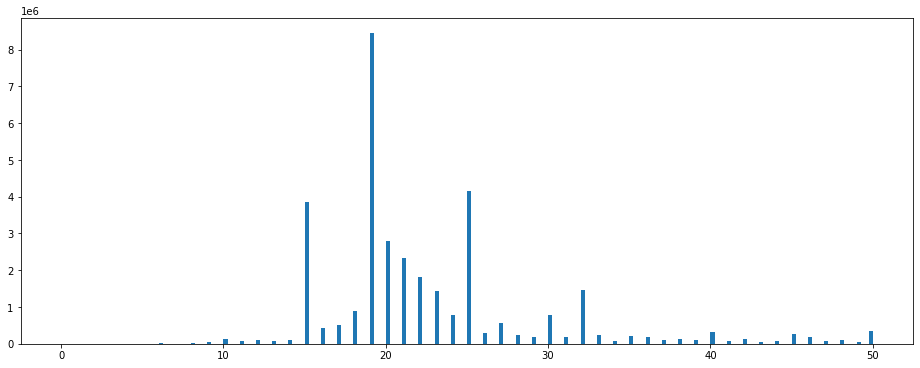

In [53]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,6))
plt.hist(df_us['seq_len'], 200, range=[0, 50], align='mid')

In [52]:
from scipy import stats
stats.mode(df_us['seq_len'])

ModeResult(mode=array([19]), count=array([8447682]))

In [49]:
#pd.set_option('display.max_colwidth', np.max(df_us['seq_len']))

### Running BlastX

In [81]:
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [85]:
from Bio.Blast.Applications import NcbiblastpCommandline
#from io.StringIO import StringIO
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Create two sequence files
seq1 = SeqRecord(Seq(all_small_seqs[1]),
                   id="seq1")
SeqIO.write(seq1, "seq1.fasta", "fasta")

# Run BLAST and parse the output as XML
output = NcbiblastxCommandline(query="seq1.fasta",outfmt=5, db='nr', remote=True)()[0]
blast_result_record = NCBIXML.read(StringIO(output))

In [89]:
blast_result_record

In [91]:
print(blast_result_record.alignments[0])

gb|AAA72784.1| [Arg-15,Glu-52] aprotinin [synthetic construct]
           Length = 59



In [98]:
new_al = blast_result_record.alignments[0]

In [100]:
new_al.hsps

In [102]:
for alignment in blast_result_record.alignments[0:2]:
    new_al = alignment
    for hsp in new_al.hsps:
        print('****Alignment****')
        print('sequence:', alignment.title)
        print('length:', alignment.length)
        print('e value:', hsp.expect)
        print(hsp.query)
        print(hsp.match)
        print(hsp.sbjct)

****Alignment****
sequence: gb|AAA72784.1| [Arg-15,Glu-52] aprotinin [synthetic construct]
length: 59
e value: 4.13503e-34
MRPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCERTCGG
MRPDFCLEPPYTGPC+ARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCERTCGG
MRPDFCLEPPYTGPCRARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCERTCGG
****Alignment****
sequence: gb|ABX57797.1| aprotinin precursor [Plastid transformation vector pAPR20]
length: 104
e value: 6.65246e-34
RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCERTCGG
RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDC RTCGG
RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCMRTCGG


### Without US patents

Patents from the US all have 'unknown.' organisms. Manual screening by opening gbpat files on text editor also does not show another way of reporting the organism names. All US patents to be removed from database.

In [43]:
# Drop all US patents
df_no_us = df[df.patent != 'Patent: US']

In [44]:
# Extracting a sample to check - can only get the first 1 million rows because of the row limitation in Excel 
#df[df.patent=='Patent: US'][:1000000].to_excel('/home/agnes/Patents_US_V2.xlsx',sheet_name='USpatents')

In [45]:
len(df_no_us) #37,527,728 matching 17,279,891 US patents removed

37527728

In [46]:
# A list with all unique species without US patents (n=14,627) - same length to all patents, sent to Robert for marine checkup
df_no_us.organism.value_counts()

organism  homo sapiens                          15878778
organism  synthetic construct                   15650123
organism  unidentified                           1529836
organism  saccharomyces pastorianus               977914
organism  mus musculus                            752565
                                                  ...   
organism  pseudomonas sp. wo2008034648_36776           1
organism  actinomyces urogenitalis dsm 15434           1
organism  hamigera sp. (in: fungi)                     1
organism  methanoregula formicica smsp                 1
organism  ursus thibetanus                             1
Name: organism, Length: 14627, dtype: int64

In [47]:
# Create an excel sheet for list of all patents 
df_no_us.organism.value_counts().to_excel('/home/agnes/Species_nous_patents_V3.xlsx', sheet_name='nous')

In [48]:
# All organism names in df starts with 'organism', but with some variations
# not all organisms start with 'organism ' with one space at the end
df_no_us.organism.apply(lambda x: x.startswith('organism ')).value_counts() #37,526,493 with ' '

True     37526493
False        1235
Name: organism, dtype: int64

In [49]:
# 1,235 starts with 'organism,' or 'organisms', checked here: 
df_no_us.organism.apply(lambda x: x.startswith('organism,')).value_counts() #63 with ','

False    37527665
True           63
Name: organism, dtype: int64

In [50]:
df_no_us.organism.apply(lambda x: x.startswith('organisms')).value_counts() #1172 with 's'

False    37526556
True         1172
Name: organism, dtype: int64

In [51]:
# Remove starting 'organism' + one more character to account ' ', ',', or 's' from df, so we can join it with the species list 
df_no_us['organism'] = df_no_us.organism.apply(lambda x: x[9:].strip())

/tmp/ipykernel_298709/3173691265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_us['organism'] = df_no_us.organism.apply(lambda x: x[9:].strip())


In [52]:
len(df_no_us.organism.value_counts())

14627

In [53]:
df_no_us.head()

,id,organism,journal,filename,origin,year,patent,company
0,1,cauliflower mosaic virus,JOURNAL Patent: EP 0242016-A1 1 21-OCT-1987;...,gbpat1.seq.gz,gttttgtttgatggagaattgcgcagaggggttatatctgcgtgag...,1987,Patent: EP,AGRICULTURAL GENETICS COMPANY LIMITED
1,2,bos taurus,JOURNAL Patent: EP 0238993-A2 1 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagccgccgtacactgggcc...,1987,Patent: EP,BAYER AG
2,3,bos taurus,JOURNAL Patent: EP 0238993-A2 2 30-SEP-1987;...,gbpat1.seq.gz,caagctttactaaggaccaccgcaagtacgttcgcagtcttccgcg...,1987,Patent: EP,BAYER AG
3,4,synthetic construct,JOURNAL Patent: EP 0238993-A2 3 30-SEP-1987;...,gbpat1.seq.gz,aattcatgcgtccggacttctgcctcgagc,1987,Patent: EP,BAYER AG
4,5,synthetic construct,JOURNAL Patent: EP 0238993-A2 4 30-SEP-1987;...,gbpat1.seq.gz,cagaagtccggacgcatg,1987,Patent: EP,BAYER AG


### Some more basic stats by Agnes

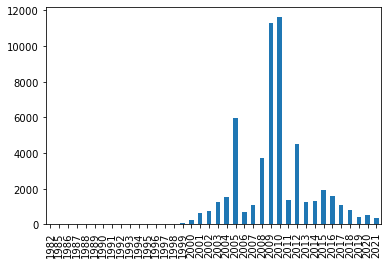

In [63]:
df_marine.year.value_counts().sort_index().plot(kind='bar') # patents per year

In [64]:
# 364 marine patents have no company info
df_marine[df_marine.company.isnull()].shape

(364, 8)

In [65]:
df_marine[df_marine.company.isnull()].year.value_counts().sort_index()

1988     1
1991    14
1992     1
1993     4
1999     7
2000    18
2001    16
2002    36
2003    94
2004    53
2005    69
2006    45
2007     6
Name: year, dtype: int64

In [66]:
df_marine.organism.value_counts()
# From 1,488 marine species, only 1,484 species are included - 4 removed with US patents

ciona intestinalis         5320
gadus morhua               3139
vibrio cholerae            1362
anguilla japonica          1202
prochlorococcus marinus     938
                           ... 
vibrio plasmid p0908          1
anemonia                      1
exocoetus volitans            1
echinophyllia                 1
tetronarce tokionis           1
Name: organism, Length: 1484, dtype: int64

In [67]:
len(df_marine) #length is still the same as before removing US patents

54042

In [68]:
# Make a matrix of how many marine species is patented by each jurisdiction
pd.crosstab(df_marine.organism,df_marine.patent).to_excel('/home/agnes/Species_per_jurisdiction_V3.xlsx', sheet_name='nous')

In [70]:
len(df_marine.origin.value_counts()) #29,301 unique marine genetic sequences

29301

In [71]:
# Make a matrix of how many marine species is patented by each jurisdiction
pd.crosstab(df_marine.origin,df_marine.patent).to_excel('/home/agnes/Origin_per_jurisdiction_V3.xlsx', sheet_name='nous')

In [72]:
# Make a matrix of how many marine species is patented by each company - not informative, maybe useful at country level
#pd.crosstab(df_marine.origin,df_marine.company).to_excel('/home/agnes/Origin_per_company_V3.xlsx', sheet_name='allorigin')

In [73]:
# Make a matrix of how many genetic sequence is associated with each marine species
pd.crosstab(df_marine.origin,df_marine.organism).to_excel('/home/agnes/Origin_per_species_V3.xlsx', sheet_name='nous')

In [74]:
# Exporting the findings to Excel
df_marine.to_excel('/home/agnes/Marine_nous_patents_V3.xlsx', sheet_name='nous')

### Remarks 

The df_marine was exported to Excel and from here on it was treated manually. 
Affiliated companies were grouped together, and a few species were excluded since they after further investigation were considered not marine.
The final, cleaned, dataset is included with the article. 
More information about this manual process can be given by Robert. 

### Endangered marine-only

Similar list as above is extracted for marine species listed in the IUCN Red List.

In [76]:
# Load file with IUCN endangered marine species (59 organisms), received from Robert Blasiak on 11 Mar 2022
mdf_iucn = pd.read_excel('/home/agnes/Marine_species_IUCN_V3.xlsx')

In [77]:
mdf_iucn.shape

(59, 2)

In [78]:
# Keep only the engangered marine sequences from df
df_iucn = df_no_us.merge(mdf_iucn, left_on='organism', right_on='organism', how='inner')

In [79]:
df_iucn.shape # 5,826 patents, additional column for IUCN category

(5826, 9)

In [80]:
df_iucn.head()

,id,organism,journal,filename,origin,year,patent,company,category
0,2390,anguilla anguilla,JOURNAL Patent: WO 8803949-A1 2 02-JUN-1988;,gbpat1.seq.gz,cgataacaccggtaaacaatcgtcactgtaggtctaaactacaaac...,1988,Patent: WO,None,critically endangered
1,7246380,anguilla anguilla,JOURNAL Patent: WO 2012160278-A1 35 29-NOV-2...,gbpat131.seq.gz,cctcgaataacaataaagacaattcataaaacaataagaacaaaaa...,2012,Patent: WO,"UNIV GRENOBLE 1 [FR], CENTRE NAT RECH SCIENT [...",critically endangered
2,8038155,anguilla anguilla,JOURNAL Patent: WO 2012160277-A1 90 29-NOV-2...,gbpat135.seq.gz,tcaaccttaaacaacgatgacaacatacaaatatcatccgccaggg...,2012,Patent: WO,"UNIV GRENOBLE 1 [FR], CENTRE NAT RECH SCIENT [...",critically endangered
3,14184745,anguilla anguilla,JOURNAL Patent: JP 2005514037-A 42 19-MAY-20...,gbpat16.seq.gz,atacctttacatagaaaca,2005,Patent: JP,Bio Merieux,critically endangered
4,19648958,anguilla anguilla,JOURNAL Patent: KR 1020067001172-A 27 18-JAN...,gbpat19.seq.gz,ggattgatgacatacaaacttctggtaagctggtagcaatggtaag...,2006,Patent: KR,None,critically endangered


In [81]:
len(df_iucn.organism.value_counts())

59

In [82]:
df_iucn.organism.value_counts()[:20]

gadus morhua                 3139
anguilla japonica            1202
takifugu rubripes             761
haliotis tuberculata          140
hippoglossus hippoglossus      89
tachypleus tridentatus         84
ginglymostoma cirratum         74
limulus polyphemus             63
thunnus orientalis             60
acropora aspera                19
porites murrayensis            18
acropora millepora             16
nematostella vectensis         15
acropora aculeus               14
pavona decussata               12
physeter catodon               11
epinephelus bruneus            10
trachyphyllia geoffroyi         9
montipora efflorescens          7
anguilla anguilla               7
Name: organism, dtype: int64

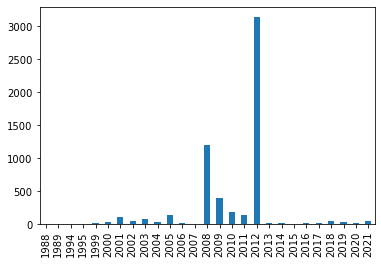

In [83]:
df_iucn.year.value_counts().sort_index().plot(kind='bar') # patents per year

In [84]:
# 364 marine patents have no company info
df_iucn[df_iucn.company.isnull()].shape

(4, 9)

In [85]:
df_iucn[df_iucn.company.isnull()].year.value_counts().sort_index()

1988    1
2001    1
2002    1
2006    1
Name: year, dtype: int64

In [87]:
# Make a matrix of how many marine species is patented by each jurisdiction
pd.crosstab(df_iucn.organism,df_iucn.patent).to_excel('/home/agnes/Species_per_jurisdiction_IUCN_V3.xlsx', sheet_name='iucn_nous')

In [88]:
len(df_iucn.origin.value_counts()) #5,032 unique marine genetic sequences for IUCN Red List species

5031

In [89]:
# Make a matrix of how many marine species is patented by each jurisdiction
pd.crosstab(df_iucn.origin,df_iucn.patent).to_excel('/home/agnes/Origin_per_jurisdiction_IUCN_V3.xlsx', sheet_name='iucn_nous')

In [90]:
# Make a matrix of how many genetic sequence is associated with each marine species
pd.crosstab(df_iucn.origin,df_iucn.organism).to_excel('/home/agnes/Origin_per_species_IUCN_V3.xlsx', sheet_name='iucn_nous')

In [86]:
# Exporting the findings to Excel
df_iucn.to_excel('/home/agnes/Marine_nous_IUCN_patents_V3.xlsx', sheet_name='iucn_nous')